<a href="https://colab.research.google.com/github/aimalz/TheLastMetric/blob/master/FigureTLMvsRedshift.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Initial downloads and installs

In [1]:
!pip install --quiet pzflow corner
!git clone https://github.com/aimalz/TheLastMetric.git
%cd TheLastMetric

     |████████████████████████████████| 7.8MB 5.3MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
Cloning into 'TheLastMetric'...
remote: Enumerating objects: 404, done.
remote: Counting objects: 100% (404/404), done.
remote: Compressing objects: 100% (344/344), done.
remote: Total 404 (delta 109), reused 321 (delta 58), pack-reused 0
Receiving objects: 100% (404/404), 24.63 MiB | 30.32 MiB/s, done.
Resolving deltas: 100% (109/109), done.
/content/TheLastMetric


## Imports and downloading data

In [2]:
%pylab inline
from utils import load_data, compute_last_metric
import corner
from pzflow import Flow

Populating the interactive namespace from numpy and matplotlib


In [3]:
# Loading data
z_cats, phot_cats, available_os, os_names, os_colors = load_data()

In [5]:
# Loading pre-trained flows
flows = {}
for os in available_os:
  flows[os] = [Flow(file=f"trained_flows/flow_for_run_{os}_%d.pkl"%(i+1) ) for i in range(10)]

In [40]:
# Computing metric for each observing strategy
all_tlm = {}
for which_os in available_os:
  all_tlm[which_os] = np.stack([ (compute_last_metric(f,
                                          phot_cats[which_os],
                                          z_cats[which_os], entropy_nbins=60)) for f in flows[which_os] ], axis=0)
  print((os_names[which_os], np.mean(all_tlm[which_os]), np.std(np.mean(all_tlm[which_os], axis=1))))

('baseline_v1_5_10yrs', 3.2027812, 0.010822993)
('footprint_stuck_rollingv1_5_10yrs', 3.0247166, 0.0105968965)
('ddf_heavy_nexp2_v1_6_10yrs', 3.115222, 0.0069252597)
('footprint_newAv1_5_10yrs', 3.1257584, 0.0065778308)
('third_obs_pt60v1_5_10yrs', 3.2072973, 0.0065919575)
('barebones_v1_6_10yrs', 3.2660677, 0.010776809)


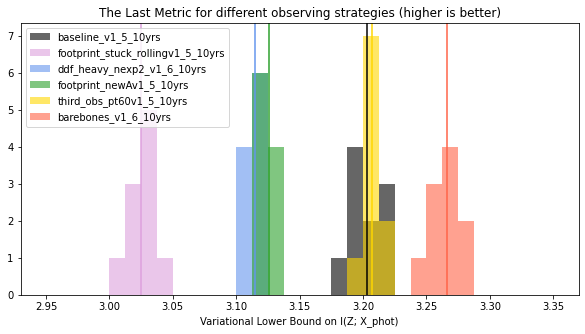

In [97]:
figure(figsize=(10,5))
for which_os in available_os:
  hist(np.mean(all_tlm[which_os],axis=1), 32, range=[2.95, 3.35], alpha=0.6, color=os_colors[which_os], label=os_names[which_os])
  axvline(np.mean(all_tlm[which_os]), color=os_colors[which_os])
legend()
xlabel('Variational Lower Bound on I(Z; X_phot)')
title('The Last Metric for different observing strategies (higher is better)')
savefig('metrics.pdf')

## Approximating the Mutual Information Lower Bound

We use a normalizing flow to approximate the distribution of redshift and photometry.

This plot should show the redshift posterior distribution for given photometry $q_\theta(z | x_{phot})$. 

We are going to use that to compute our lower bound on the mutual information

$$I(z; x_{phot})  \geq \mathbb{E}_{z, x_{phot}} \left[ q_\theta(z | x_{phot}) \right]  + H(z)$$ 

The second term in this bound only depends on the true redshift distribution, which stays constant between observing strategies. Only the first term depends on the observed photometry, so it is the only one we have to compare between `OpSim` runs.

In [91]:
from scipy import stats
n=32
b = stats.mstats.mquantiles(z_cats[which_os]['z_true'], np.linspace(0,1,n, endpoint=True))

In [92]:
# Computing the metric in redshift bins
mis = {}

for which_os in available_os:
  inds = digitize(z_cats[which_os]['z_true'], b) -1 
  res = zeros(n-1)
  for i in range(n-1):
    res[i] = np.mean( np.mean([(all_tlm[which_os][j].flatten()[inds == i]) for j in range(10)]))
    
  mis[which_os] = res

In [93]:
b_centers = 0.5*(b[1:] + b[:1])

Text(0.5, 0, 'z')

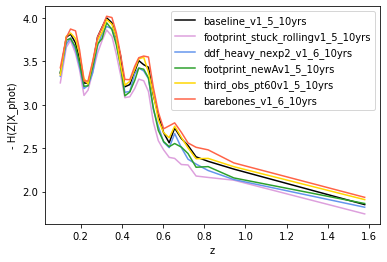

In [94]:
for which_os in available_os:
  plot(b_centers, mis[which_os], label=os_names[which_os], color=os_colors[which_os])
legend()
ylabel('- H(Z|X_phot)')
xlabel('z')

(-0.6, 0.6)

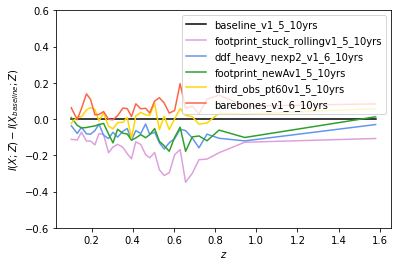

In [95]:
for which_os in available_os:
  plot(b_centers, mis[which_os] - mis['1_4_y10'], label=os_names[which_os], color=os_colors[which_os])
legend(loc='upper right')
xlabel('$z$')
ylabel('$I(X ; Z) - I(X_{baseline} ; Z)$');
savefig('figure4.pdf')
ylim(-0.6,0.6)